# <u>Submission instructions</u>
### Submission in pairs unless otherwise authorized
<ul style="font-size: 17px">
<li> This notebook contains all the questions. You should follow the instructions below.</li>
<li> Solutions for both theoretical and practical parts should be written in this notebook</li>
</ul>

<h3> Moodle submission</h3>


<p style="font-size: 17px">
You should submit three files:
</p>
<ul style="font-size: 17px">
<li>IPYNB notebook:
  <ul>
  <li>All the wet and dry parts, including code, graphs, discussion, etc.</li>
  </ul>
</li>
<li>PDF file:
  <ul>
  <li>Export the notebook to PDF. Make sure that all the cells are visible.</li>
  </ul>
</li>
</ul>
<p style="font-size: 17px">
All files should be in the following format: "HW2_ID1_ID2.file"
<br>
Good Luck!
</p>

In [1]:
# Unzip files
!unzip /content/HW2_data.zip -d /content/


Archive:  /content/HW2_data.zip
  inflating: /content/testEmotions.csv  
  inflating: /content/trainEmotions.csv  


# Question 1 - Generalizrtion and Overfit (30 pt)

<p style="font-size: 17px"> In this exercise, we will demonstrate overfitting to random labels. The settings are the following:
<ul style="font-size: 17px">
<li> Use the MNIST dataset.
<li> Work on the first 128 samples from the training dataset.
<li> Fix the following parameters:
    <ul>
        <li> Shuffle to False.
        <li> Batch size to 128.
    </ul>
<li> Generate random labels from Bernoulli distribution with a probability of $\frac{1}{2}$. I.e., each sample is assigned a random label which is zero or one.
</ul>

<p style="font-size: 17px">
Show that by using a Fully Connected netwrok and cross-entropy loss, you are able to achieve a loss value of ~0 (the lower the better).
Plot the accuracy and loss convergence for this data and the test data as a function of epochs.
What is the accuracy value of the test data? Explain
</p>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data = mnist_train.data[:128].float() / 255.0  # Normalize data
labels = torch.bernoulli(torch.full((128,), 0.5)).long()  # Random labels (Bernoulli with p=0.5)


class RandomLabelDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx].view(-1), self.labels[idx]  # Flatten images

dataset = RandomLabelDataset(data, labels)
dataloader = DataLoader(dataset, batch_size=128, shuffle=False)


# Define Fully Connected
class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Output layer for 2 classes
        )

    def forward(self, x):
        return self.fc(x)

model = FCNet().to(device)  # Move model to GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Load test data
test_loader = DataLoader(mnist_train, batch_size=128, shuffle=False)


# Training loop and evaluation
epochs = 80
train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []

for epoch in range(epochs):
    model.train()
    correct_train = 0
    epoch_train_loss = 0

    # Training
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training metrics
        epoch_train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct_train += (preds == targets).sum().item()

    train_loss.append(epoch_train_loss / len(dataloader))
    train_accuracy.append(correct_train / len(dataset) * 100)

    # Evaluation
    model.eval()
    correct_test = 0
    epoch_test_loss = 0
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.view(-1, 28 * 28).to(device)  # Flatten and move to GPU
            outputs = model(inputs)
            loss = criterion(outputs, torch.zeros(len(inputs), dtype=torch.long, device=device))  # Labels on GPU
            epoch_test_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct_test += (preds == 0).sum().item()

    test_loss.append(epoch_test_loss / len(test_loader))
    test_accuracy.append(correct_test / len(mnist_train) * 100)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_accuracy[-1]:.2f}%, Test Loss: {test_loss[-1]:.4f}, Test Acc: {test_accuracy[-1]:.2f}%")

Epoch 1/80, Train Loss: 0.6958, Train Acc: 50.00%, Test Loss: 0.6619, Test Acc: 95.03%
Epoch 2/80, Train Loss: 0.6836, Train Acc: 55.47%, Test Loss: 0.6907, Test Acc: 55.55%
Epoch 3/80, Train Loss: 0.6743, Train Acc: 75.78%, Test Loss: 0.7088, Test Acc: 37.98%
Epoch 4/80, Train Loss: 0.6645, Train Acc: 71.88%, Test Loss: 0.7161, Test Acc: 36.56%
Epoch 5/80, Train Loss: 0.6536, Train Acc: 75.78%, Test Loss: 0.7159, Test Acc: 40.21%
Epoch 6/80, Train Loss: 0.6418, Train Acc: 77.34%, Test Loss: 0.7139, Test Acc: 43.91%
Epoch 7/80, Train Loss: 0.6286, Train Acc: 76.56%, Test Loss: 0.7177, Test Acc: 44.83%
Epoch 8/80, Train Loss: 0.6139, Train Acc: 78.12%, Test Loss: 0.7274, Test Acc: 44.22%
Epoch 9/80, Train Loss: 0.5975, Train Acc: 79.69%, Test Loss: 0.7364, Test Acc: 44.28%
Epoch 10/80, Train Loss: 0.5802, Train Acc: 80.47%, Test Loss: 0.7362, Test Acc: 46.32%
Epoch 11/80, Train Loss: 0.5616, Train Acc: 83.59%, Test Loss: 0.7317, Test Acc: 48.60%
Epoch 12/80, Train Loss: 0.5419, Train Ac

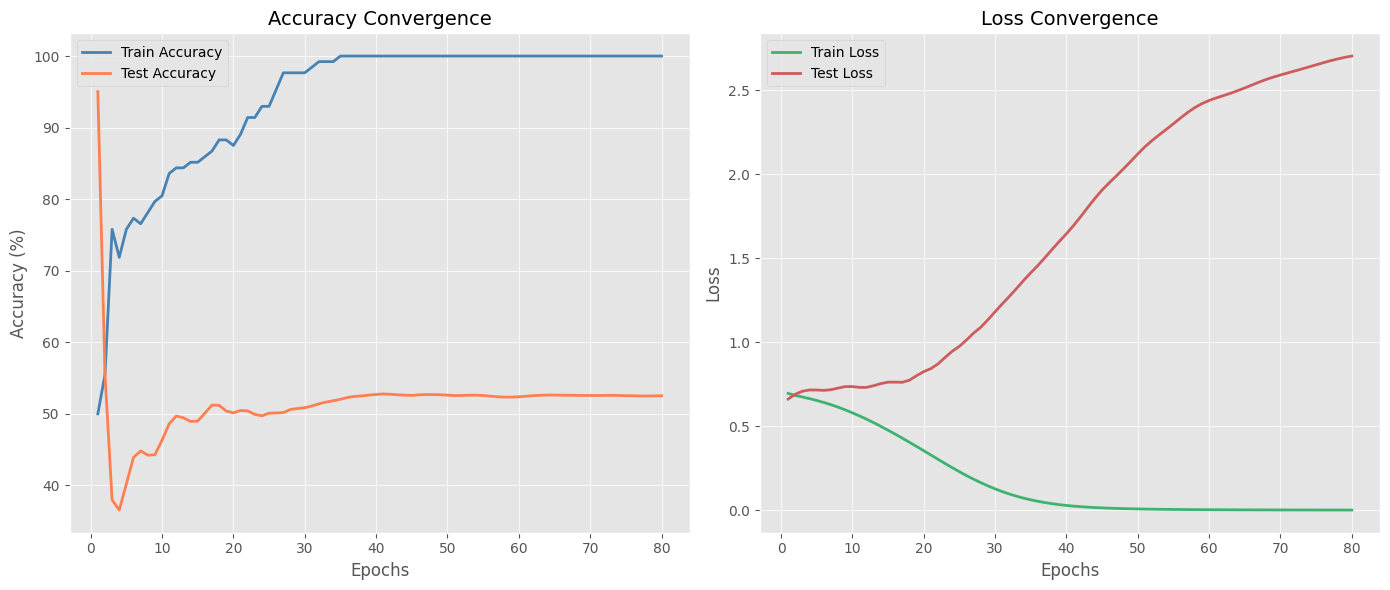

In [ ]:
# Use a built-in style
plt.style.use('ggplot')

# Plotting accuracy and loss convergence
plt.figure(figsize=(14, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_accuracy, label='Train Accuracy', color='steelblue', linewidth=2)
plt.plot(range(1, epochs + 1), test_accuracy, label='Test Accuracy', color='coral', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Accuracy Convergence', fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.7)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_loss, label='Train Loss', color='mediumseagreen', linewidth=2)
plt.plot(range(1, epochs + 1), test_loss, label='Test Loss', color='indianred', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Convergence', fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.7)

# Apply tight layout and show the plots
plt.tight_layout()
plt.show()


In [ ]:
print(f"Final Test Accuracy: {test_accuracy[-1]:.2f}%")

Final Test Accuracy: 52.53%


Overfitting happens when a model learns the training data so well that it also learns its noise and outliers, and performs poorly on new, unseen data. In our case, the model memorizes random labels, achieving near-zero loss on the training set. However, because these labels lack meaningful patterns, the model fails to generalize, resulting in test accuracy comparable to random guessing (~50%). This situation underscores the risks of overfitting and highlights the necessity of employing meaningful labels and regularization techniques to enhance model generalization. Without meaningful labels, the model cannot generalize and produce a useful evaluation metric on test data.

<h1> Question 2 - Sentiment Analysis - Classification (70 pt)</h1>

### Exercise
<p style="font-size: 17px">
The goal of this exercise is to get familiar with recurrent neural networks.
<br><br>
The field of detecting which emotion is represented in a text is developing and being
studied due to its usefulness. For example, detecting if a review is positive or
negative and more.
<br><br>
In this exercise, you will detect the emotion of a sentence. You should get at least 47% accuracy on the test set.
<br><br>
You should
<ul style="font-size: 17px">
  <li> Try different model architectures - Vanilla RNN and Gated model (GRU/LSTM)</li>
  <li> Use different optimization and regularization methods </li>
  <li> Try different combinations of hyperparamters</li>
</ul>
</p>

<br>

### Data

<p style="font-size: 17px">
The data is a csv file containing tweets and their labels according to the emotion –
{happiness, sadness, neutral}. Every row in the file (except for the header) is an
example.
<br>
Examples: (Notepad++ view)
<ul style="font-size: 17px">
  <li> happiness,Welcome @doeko ! Really glad to know you here. Your products rox man</li>
  <li> sadness,Disappointment really sucks! I'm getting used to it.</li>
  <li> neutral,I just want to Sleep.</li>
</ul>
<p style="font-size: 17px">
You have a train file – "trainEmotions.csv" and a test file – "testEmotions.csv". Both files can be found in the "HW2_data.zip" file.
</p>

### Tips

<p style="font-size: 17px">
Instead of using One-hot embeddings for the data, use <code>nn.Embedding</code>.
You also might add "Start Of Sentence" (SOS) and "End Of Sentence" (EOS) embeddings.
</p>

### a) EDA (10 pt)

<p style="font-size: 17px">
Explore and analyze your data. Explain your data cleaning and processing pipeline.
</p>

In [2]:
!pip install torch torchvision torchaudio torchtext --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchtext to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.5 MB/s eta 0:00:00
INFO: pip is still looking at multiple versions of torchtext to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pad_sequence
import re

def load_data(train_file, test_file):
    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)
    return train_data, test_data

def explore_data(train_data, test_data):
    # Print train statistics and data
    print("Train data info:")
    print(train_data.info())
    # Train label distribution
    print("\nTrain class distribution:")
    print(train_data['emotion'].value_counts())
    train_data['emotion'].value_counts().plot(kind='bar', title='Label Distribution')
    plt.show()

    # Print test statistics and data
    print("\nTest data info:")
    print(test_data.info())
    # Test label distribution
    print("\nTest class distribution:")
    print(test_data['emotion'].value_counts())

    # Compare tweet lengths
    train_data['tweet_length'] = train_data['content'].apply(lambda x: len(x.split()))
    test_data['tweet_length'] = test_data['content'].apply(lambda x: len(x.split()))

    plt.hist(train_data['tweet_length'], bins=30, alpha=0.5, label='Train')
    plt.hist(test_data['tweet_length'], bins=30, alpha=0.5, label='Test')
    plt.legend()
    plt.title('Tweet Length Distribution')
    plt.xlabel('Length')
    plt.ylabel('Frequency')
    plt.show()

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    return text.lower().strip()

def preprocess_data(data, vocab=None):
    tokenizer = get_tokenizer('basic_english')
    data['tokens'] = data['cleaned_content'].apply(tokenizer)

    if vocab is None:
        vocab = {word: i + 1 for i, word in enumerate(set(token for tokens in data['tokens'] for token in tokens))}
        vocab['<PAD>'] = 0

    data['encoded'] = data['tokens'].apply(lambda x: [vocab.get(token, 0) for token in x])
    return data, vocab

def pad_sequences(encoded_data, max_len=None):
    sequences = [torch.tensor(seq, dtype=torch.long) for seq in encoded_data]
    return pad_sequence(sequences, batch_first=True, padding_value=0)

def prepare_data_loaders(train_encoded, test_encoded, train_labels, test_labels, batch_size=32):
    train_dataset = TensorDataset(train_encoded, train_labels)
    test_dataset = TensorDataset(test_encoded, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

Train data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14504 entries, 0 to 14503
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  14504 non-null  object
 1   content  14504 non-null  object
dtypes: object(2)
memory usage: 226.8+ KB
None

Train class distribution:
emotion
happiness    5430
neutral      5182
sadness      3892
Name: count, dtype: int64


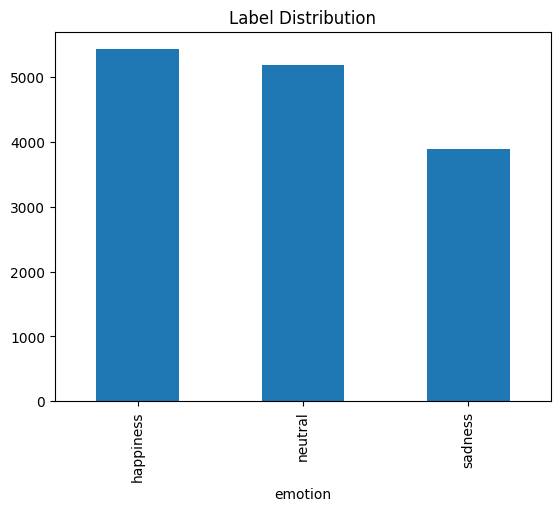


Test data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4837 entries, 0 to 4836
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  4837 non-null   object
 1   content  4837 non-null   object
dtypes: object(2)
memory usage: 75.7+ KB
None

Test class distribution:
emotion
happiness    1811
neutral      1728
sadness      1298
Name: count, dtype: int64


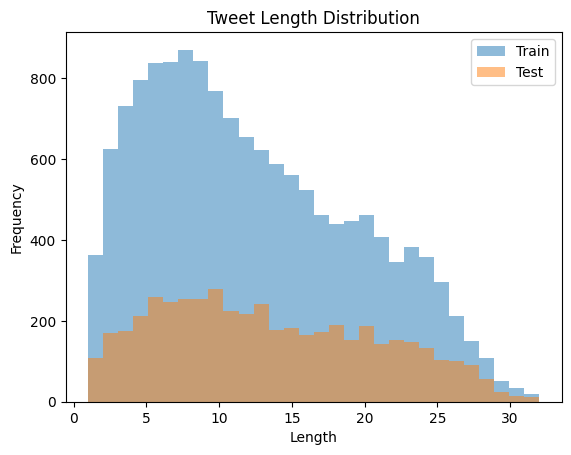

In [4]:
train_file = 'trainEmotions.csv'
test_file = 'testEmotions.csv'

# Load and Explore Data
train_data, test_data = load_data(train_file, test_file)
explore_data(train_data, test_data)

# Apply cleaning
train_data['cleaned_content'] = train_data['content'].apply(clean_text)
test_data['cleaned_content'] = test_data['content'].apply(clean_text)

# Encode Labels
label_encoder = LabelEncoder()
train_data['label'] = label_encoder.fit_transform(train_data['emotion'])
test_data['label'] = label_encoder.transform(test_data['emotion'])

# Tokenize and Encode
train_data, vocab = preprocess_data(train_data)
test_data, _ = preprocess_data(test_data, vocab)

# Pad Sequences and Prepare Data Loaders
train_padded = pad_sequences(train_data['encoded'])
test_padded = pad_sequences(test_data['encoded'])

# Convert labels to tensors
train_labels = torch.tensor(train_data['label'].values, dtype=torch.long)
test_labels = torch.tensor(test_data['label'].values, dtype=torch.long)

# Prepare Data Loaders
train_loader, test_loader = prepare_data_loaders(train_padded, test_padded, train_labels, test_labels)

### b) Main (50 pt)

<p style="font-size: 17px">
Define 2 models, as requested. Train and eval them.
<ul style="font-size: 17px">
<li> Plot the gated model's accuracy and loss (both on train and test sets) as a function of the epochs.
<li> Plot a confusion matrix
</ul>

</p>

In [5]:

# Defining an RNN model
class VanillaRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(VanillaRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        out, _ = self.rnn(embedded)
        out = out[:, -1, :]  # Take the output at the last time step
        return self.fc(out)

# Defining a GRU
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        out, _ = self.gru(embedded)
        out = out[:, -1, :]  # Take the output at the last time step
        return self.fc(out)

NameError: name 'nn' is not defined

In [ ]:
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss, correct, total = 0, 0, 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = epoch_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluate on test set
        model.eval()
        test_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        test_loss /= len(test_loader)
        test_accuracy = correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

    return train_losses, test_losses, train_accuracies, test_accuracies


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_comparison(train_losses_rnn, test_losses_rnn, train_losses_gru, test_losses_gru, train_accuracies_rnn, test_accuracies_rnn, train_accuracies_gru, test_accuracies_gru):
    epochs = len(train_losses_rnn)

    # Plot Loss comparison
    plt.figure(figsize=(10, 6))
    plt.plot(range(epochs), train_losses_rnn, label='Train Loss RNN', linestyle='--')
    plt.plot(range(epochs), test_losses_rnn, label='Test Loss RNN', linestyle='--')
    plt.plot(range(epochs), train_losses_gru, label='Train Loss GRU', linestyle='-')
    plt.plot(range(epochs), test_losses_gru, label='Test Loss GRU', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Test Loss for RNN and GRU')
    plt.legend()
    plt.show()

    # Plot Accuracy comparison
    plt.figure(figsize=(10, 6))
    plt.plot(range(epochs), train_accuracies_rnn, label='Train Accuracy RNN', linestyle='--')
    plt.plot(range(epochs), test_accuracies_rnn, label='Test Accuracy RNN', linestyle='--')
    plt.plot(range(epochs), train_accuracies_gru, label='Train Accuracy GRU', linestyle='-')
    plt.plot(range(epochs), test_accuracies_gru, label='Test Accuracy GRU', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Test Accuracy for RNN and GRU')
    plt.legend()
    plt.show()

def plot_confusion_matrix(model, data_loader, label_encoder, model_name):
    all_labels = []
    all_preds = []

    with torch.no_grad():
        model.eval()
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()



Hyperparameters: Embedded dim: 128 , Hidden dim: 64
Training Vanilla RNN...
Epoch 1/20, Train Loss: 1.0939, Train Acc: 36.34%, Test Loss: 1.0891, Test Acc: 37.44%
Epoch 2/20, Train Loss: 1.0920, Train Acc: 36.94%, Test Loss: 1.0897, Test Acc: 37.44%
Epoch 3/20, Train Loss: 1.0922, Train Acc: 37.37%, Test Loss: 1.0912, Test Acc: 35.72%
Epoch 4/20, Train Loss: 1.0914, Train Acc: 36.93%, Test Loss: 1.0990, Test Acc: 37.44%
Epoch 5/20, Train Loss: 1.0903, Train Acc: 37.10%, Test Loss: 1.0907, Test Acc: 37.36%
Epoch 6/20, Train Loss: 1.0897, Train Acc: 36.26%, Test Loss: 1.0906, Test Acc: 35.85%
Epoch 7/20, Train Loss: 1.0899, Train Acc: 36.27%, Test Loss: 1.0969, Test Acc: 37.42%
Epoch 8/20, Train Loss: 1.0870, Train Acc: 37.01%, Test Loss: 1.0902, Test Acc: 37.46%
Epoch 9/20, Train Loss: 1.0820, Train Acc: 37.29%, Test Loss: 1.1066, Test Acc: 36.92%
Epoch 10/20, Train Loss: 1.0760, Train Acc: 37.56%, Test Loss: 1.0925, Test Acc: 36.99%
Epoch 11/20, Train Loss: 1.0794, Train Acc: 37.07%, 

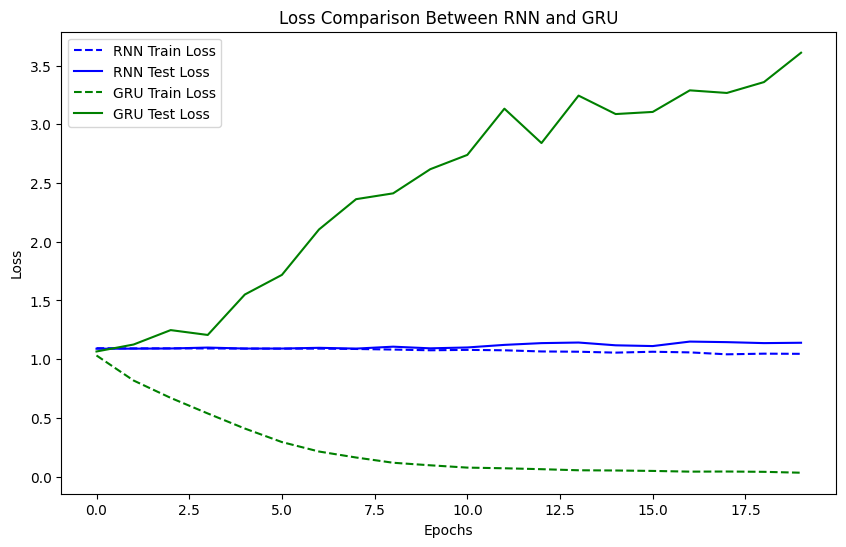

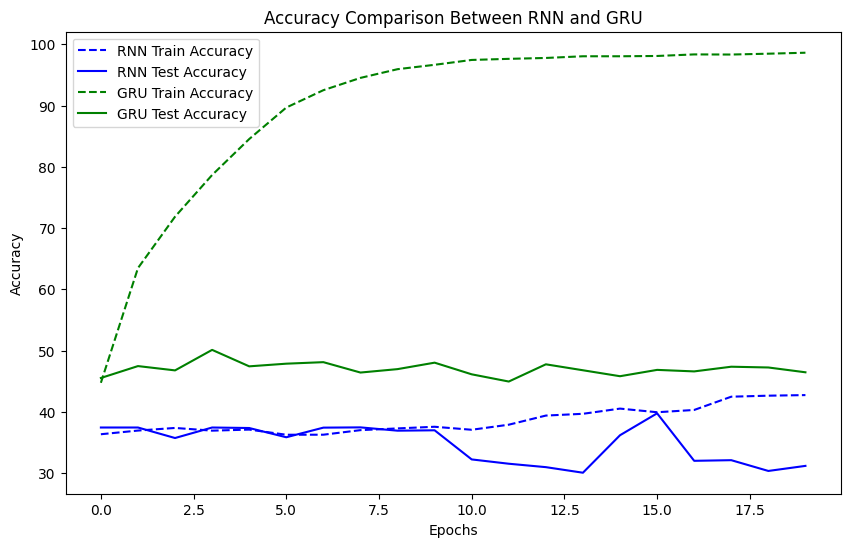

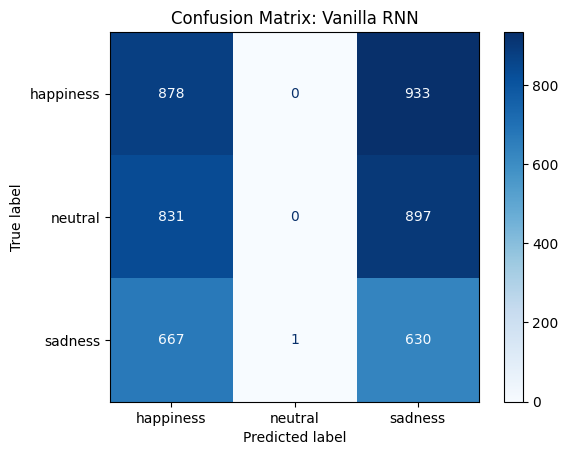

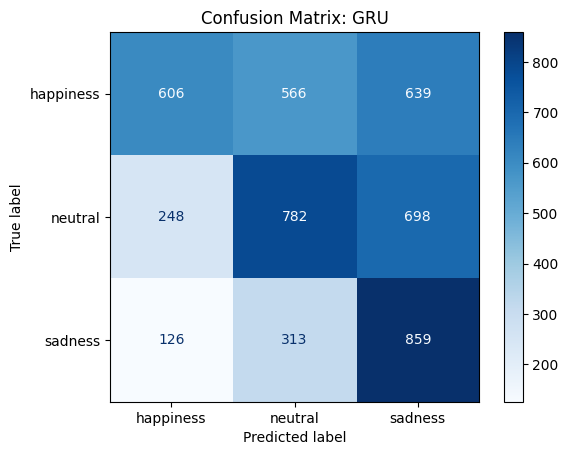


Hyperparameters: Embedded dim: 50 , Hidden dim: 100
Training Vanilla RNN...
Epoch 1/20, Train Loss: 1.0931, Train Acc: 36.85%, Test Loss: 1.0921, Test Acc: 37.42%
Epoch 2/20, Train Loss: 1.0905, Train Acc: 36.65%, Test Loss: 1.0905, Test Acc: 37.36%
Epoch 3/20, Train Loss: 1.0899, Train Acc: 37.67%, Test Loss: 1.0946, Test Acc: 35.87%
Epoch 4/20, Train Loss: 1.0894, Train Acc: 37.17%, Test Loss: 1.0964, Test Acc: 35.75%
Epoch 5/20, Train Loss: 1.0901, Train Acc: 37.16%, Test Loss: 1.0889, Test Acc: 35.79%
Epoch 6/20, Train Loss: 1.0891, Train Acc: 37.25%, Test Loss: 1.0920, Test Acc: 35.75%
Epoch 7/20, Train Loss: 1.0982, Train Acc: 36.17%, Test Loss: 1.0921, Test Acc: 36.41%
Epoch 8/20, Train Loss: 1.0956, Train Acc: 36.79%, Test Loss: 1.1182, Test Acc: 36.37%
Epoch 9/20, Train Loss: 1.0936, Train Acc: 37.51%, Test Loss: 1.0926, Test Acc: 35.33%
Epoch 10/20, Train Loss: 1.0908, Train Acc: 37.55%, Test Loss: 1.1039, Test Acc: 36.06%
Epoch 11/20, Train Loss: 1.0893, Train Acc: 37.33%, 

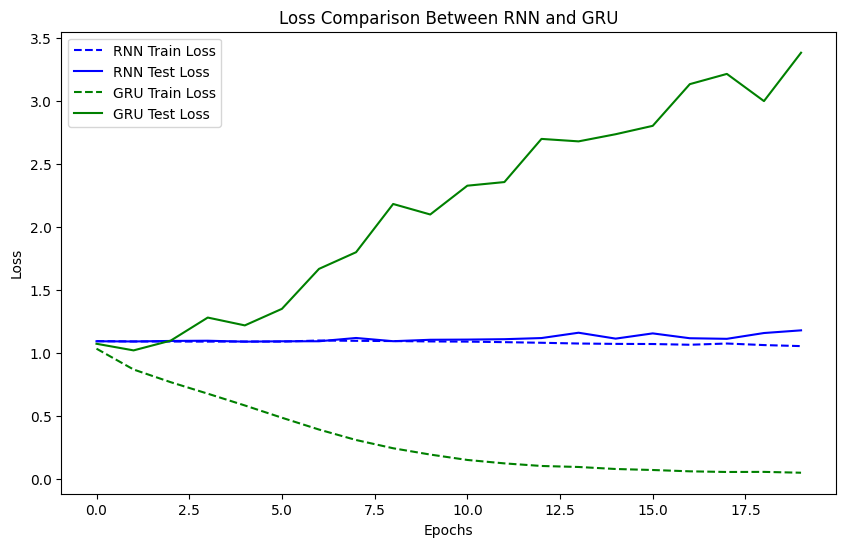

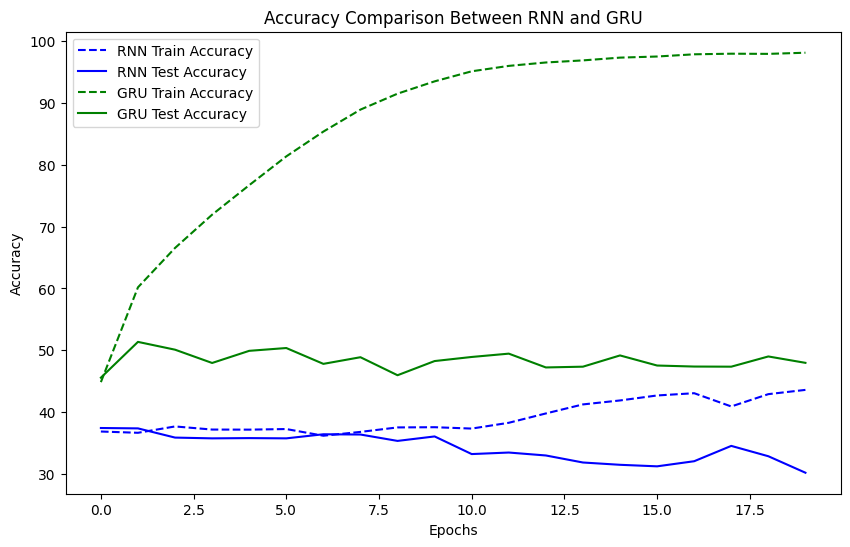

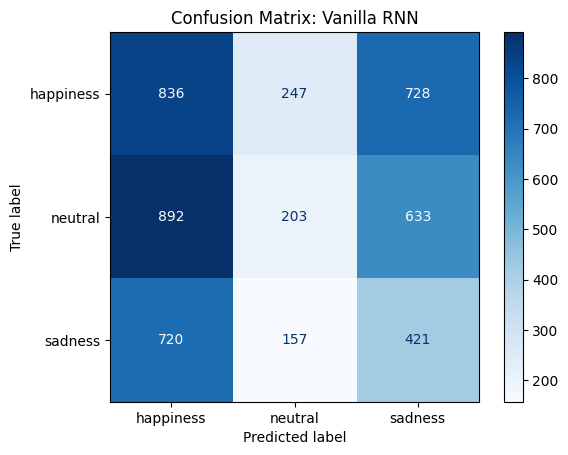

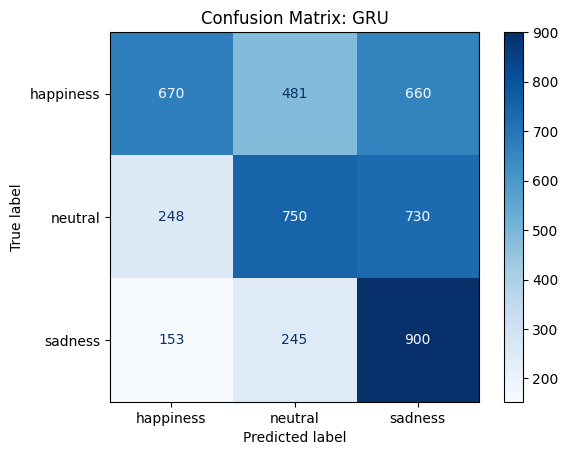

In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example Hyperparameters
hyperparams = {
    "embed_dim": [50, 128],
    "hidden_dim": [100, 64],
    "learning_rate": [0.001, 0.01],
    "batch_size": [32, 64],
    "dropout": [0.3, 0.5]
}
vocab_size = len(vocab)
num_classes = len(label_encoder.classes_)

# Train and evaluate models with different hyperparameters
for embed_dim in hyperparams["embed_dim"]:
    for hidden_dim in hyperparams["hidden_dim"]:
        for lr in hyperparams["learning_rate"]:
            for batch_size in hyperparams["batch_size"]:
                for dropout in hyperparams["dropout"]:
                    print(f"Training with embed_dim={embed_dim}, hidden_dim={hidden_dim}, lr={lr}, batch_size={batch_size}, dropout={dropout}")
                    rnn_model = VanillaRNN(vocab_size, embed_dim=embed_dim, hidden_dim=hidden_dim, num_classes=num_classes).to(device)
                    gru_model = GRUModel(vocab_size, embed_dim=embed_dim, hidden_dim=hidden_dim, num_classes=num_classes).to(device)


    # Train Vanilla RNN
    print("Training Vanilla RNN...")
    rnn_train_losses, rnn_test_losses, rnn_train_accuracies, rnn_test_accuracies = train_model(
        vanilla_rnn, train_loader, test_loader, num_epochs, learning_rate, device
    )

    # Train GRU Model
    print("Training GRU Model...")
    gru_train_losses, gru_test_losses, gru_train_accuracies, gru_test_accuracies = train_model(
        gru_model, train_loader, test_loader, num_epochs, learning_rate, device
    )


    plot_train_test_comparison(
    rnn_train_losses,
    rnn_test_losses,
    gru_train_losses,
    gru_test_losses,
    "Loss"
    )

    plot_train_test_comparison(
        rnn_train_accuracies,
        rnn_test_accuracies,
        gru_train_accuracies,
        gru_test_accuracies,
        "Accuracy"
    )

    models = [vanilla_rnn, gru_model]
    model_names = ["Vanilla RNN", "GRU"]
    plot_confusion_matrices(models, test_loader, label_encoder, device, model_names)

In [ ]:

# Plot Metrics for GRU Model
plt.figure(figsize=(12, 6))
plt.plot(range(1, 21), gru_loss, label='Train Loss', marker='o')
plt.plot(range(1, 21), test_loss, label='Test Loss', marker='x')
plt.plot(range(1, 21), gru_acc, label='Train Accuracy', marker='o')
plt.plot(range(1, 21), test_acc, label='Test Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.title('GRU Model - Accuracy and Loss Convergence')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - GRU Model')
plt.show()


NameError: name 'gru_loss' is not defined

<Figure size 1200x600 with 0 Axes>

### c) Discussion (10 pt)
<p style="font-size: 17px">
Discuss the differences in the methods you have tried.
</p>